In [3]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer# Import TF IDF 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, log_loss, roc_curve, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from typing import List 
import math
import re

In [5]:
df = pd.read_csv('mail_data.csv')
datalink = 'https://www.kaggle.com/datasets/shantanudhakadd/email-spam-detection-dataset-classification/data'
print(df.head())

  Category                                            Message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...


In [6]:
df['Category'] = df['Category'].map({'ham': 0, 'spam': 1}) # Turn spam and ham tag to 1 and 0 respactively

In [4]:
df.head()

,Category,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


# Implement TF-IDF

In [7]:
def compute_tfidf(documents):
    # 1. Tokenize and clean a document
    def tokenize(doc):
        doc = re.sub(r'[\t\n\r]', ' ', doc)                 # Replace tabs/newlines
        doc = re.sub(r'[^\w\s]', '', doc.lower())           # Remove punctuation and lowercase
        doc = re.sub(r'\s+', ' ', doc).strip()              # Normalize whitespace
        return doc.split()                                  # Tokenize by splitting words

    # 2. Tokenize all documents
    tokenized_docs = [tokenize(doc) for doc in documents]

    # 3. Build vocabulary
    vocab = sorted(set(word for doc in tokenized_docs for word in doc))

    # 4. Compute Term Frequency (TF)
    def compute_tf(doc_tokens):
        tf = {}
        total_terms = len(doc_tokens)
        if total_terms == 0:
            return {word: 0 for word in vocab}
        for word in vocab:
            tf[word] = doc_tokens.count(word) / total_terms
        return tf

    tf_list = [compute_tf(doc) for doc in tokenized_docs]

    # 5. Compute Document Frequency (DF)
    def compute_df(docs):
        df = {}
        for word in vocab:
            df[word] = sum(1 for doc in docs if word in doc)
        return df

    df = compute_df(tokenized_docs)

    # 6. Compute Inverse Document Frequency (IDF)
    def compute_idf(df, N):
        idf = {}
        for word, doc_count in df.items():
            idf[word] = math.log(N / (1 + doc_count))
        return idf

    idf = compute_idf(df, len(documents))

    # 7. Compute TF-IDF for each document
    def compute_tfidf_vector(tf, idf):
        tfidf = {}
        for word in vocab:
            tfidf[word] = tf.get(word, 0) * idf.get(word, 0)
        return tfidf

    tfidf_list = [compute_tfidf_vector(tf, idf) for tf in tf_list]

    # 8. Round and clean up result
    result = []
    for tfidf in tfidf_list:
        result.append({word: round(score, 4) for word, score in tfidf.items() if score > 0})

    # 9. Turn list of dicts into matrix
    def tfidf_to_matrix(result, vocab):
        vocab_index = {word: idx for idx, word in enumerate(vocab)}
        matrix = np.zeros((len(result), len(vocab)))

        for doc_idx, tfidf_dict in enumerate(result):
            for word, tfidf in tfidf_dict.items():
                if word in vocab_index:
                    word_idx = vocab_index[word]
                    matrix[doc_idx][word_idx] = tfidf

        return matrix
    
    matrix =  tfidf_to_matrix(result, vocab)

    return matrix


In [8]:
dataset = compute_tfidf(df['Message'])

# Implement TF-IDF using scikit-learn
1. Using data(a list of sentence)
2. Convert these text documents into numerical vectors
    - Represent how important each word is in that document
    - Based on its frequency(TF) and inverse document frequency(IDF)
3. `fit()` the data
    - Scans the text data and creates a dictionary of all word `TfidfVectorizer()`
    - Calculate how rare or common each word is across all documents(IDF) `.fit(documents)`
4. `transform()` the data(application step)
    - Convert the input documents into a numerical matrix base on the vocabulary and  IDF that were learned during `fit()`

In [9]:
scikitlearn_data = df['Message'].dropna().astype(str) # Remove missing row
# Create the vectorizer
scikitlearn_data = scikitlearn_data.str.lower().replace(r'[^\w\s]','',regex=True)
vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform text
tfidf_matrix = vectorizer.fit_transform(scikitlearn_data)

In [ ]:
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

print(tfidf_matrix[0])

# Implement Logistic regression


In [10]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

    

In [11]:
def compute_loss(x_train, y_train, w, b):
    m = x_train.shape[0]
    z = np.dot(x_train, w) + b
    h = sigmoid(z)
    epsilon = 1e-15
    loss = -np.mean(y_train * np.log(h + epsilon) + (1 - y_train) *  np.log(1 - h + epsilon))
    return loss

In [12]:
def compute_gradient(x_train, y_train, w, b):
    m = x_train.shape[0]
    z = np.dot(x_train, w) + b
    h = sigmoid(z)
    error = h - y_train
    dw = np.dot(x_train.T, error) / m
    db = np.sum(error) / m
    return dw, db

def gradient_descent(x_train, y_train, w, b, iters, lr):
    losses = []
    for i in range(iters):
        dw_dj, db_dj = compute_gradient(x_train, y_train, w, b)
        w = w - lr*dw_dj
        b = b - lr*db_dj
        loss = compute_loss(x_train, y_train, w, b)
        losses.append(loss)
        if i % math.ceil(iters / 10) == 0:
            print(f"Iteration: {i}, Cost value: {compute_loss(x_train, y_train, w, b)}")

    print("Complete gradient descent!")
    print(f"Weight: {w}, Bias: {b}\n")

    return w, b, losses

    

In [13]:
def check_threshold(x, threshold):
    if x < threshold:
        return 0
    else:
        return 1

In [14]:
X = dataset # Taken from function compute_tfidf()
y = np.array(df['Category'])

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
iters = 10000
lr_1 = 0.01


m,n = X_train.shape
w_1 = np.zeros(n,)
b_1 = 0


w_1, b_1, loss_1 = gradient_descent(X_train, y_train, w_1, b_1, iters, lr_1)

Iteration: 0, Cost value: 0.6917698229501618
Iteration: 1000, Cost value: 0.3973526189635055
Iteration: 2000, Cost value: 0.38445490294125917
Iteration: 3000, Cost value: 0.3794840859741482
Iteration: 4000, Cost value: 0.3751333234050555
Iteration: 5000, Cost value: 0.3708971221503404
Iteration: 6000, Cost value: 0.36673145368222404
Iteration: 7000, Cost value: 0.36263166572609196
Iteration: 8000, Cost value: 0.3585966960138447
Iteration: 9000, Cost value: 0.354625832969232
Complete gradient descent!
Weight: [ 0.01478585  0.00952728  0.0052442  ... -0.00446129 -0.15805026
 -0.00854035], Bias: -1.7624358685777506



In [ ]:
plt.plot(loss_1)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.title('Training loss curve with lr = 0.01')
plt.grid(True)
plt.show()

In [17]:
lr_2 = 0.05
m,n = X_train.shape
w_2 = np.zeros(n,)
b_2 = 0
w_2, b_2, loss_2 = gradient_descent(X_train, y_train, w_2, b_2, iters, lr_2)

Iteration: 0, Cost value: 0.6862955321367522
Iteration: 1000, Cost value: 0.3708798228917829
Iteration: 2000, Cost value: 0.3507021697816155
Iteration: 3000, Cost value: 0.3320952718367653
Iteration: 4000, Cost value: 0.31497723712029835
Iteration: 5000, Cost value: 0.29926147523819974
Iteration: 6000, Cost value: 0.2848543210341894
Iteration: 7000, Cost value: 0.2716572491979031
Iteration: 8000, Cost value: 0.25957017455653236
Iteration: 9000, Cost value: 0.2484945905929313
Complete gradient descent!
Weight: [ 0.06928406  0.04515783  0.0237665  ... -0.02193612 -0.56465445
 -0.03202776], Bias: -1.6705334268295895



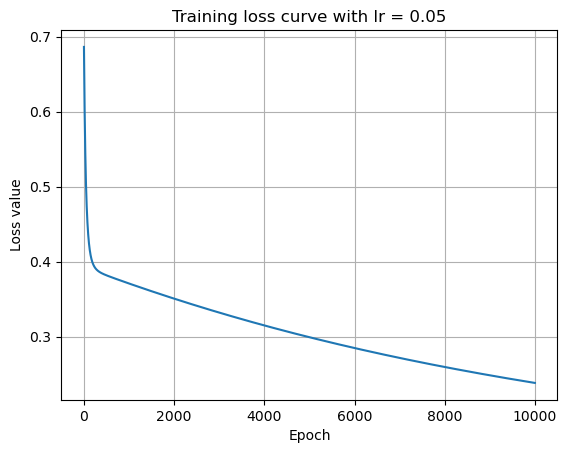

In [20]:
plt.plot(loss_2)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.title('Training loss curve with lr = 0.05')
plt.grid(True)
plt.show()

In [19]:
lr_3 = 0.1
m,n = X_train.shape
w_3 = np.zeros(n,)
b_3 = 0
w_3, b_3, loss_3 = gradient_descent(X_train, y_train, w_3, b_3, iters, lr_3)

Iteration: 0, Cost value: 0.679531725366098
Iteration: 1000, Cost value: 0.3506818645981168
Iteration: 2000, Cost value: 0.31495940832401054
Iteration: 3000, Cost value: 0.2848387755097646
Iteration: 4000, Cost value: 0.25955666227987134
Iteration: 5000, Cost value: 0.23832430785334505
Iteration: 6000, Cost value: 0.22041206984015044
Iteration: 7000, Cost value: 0.2051942305761004
Iteration: 8000, Cost value: 0.19215797011831212
Iteration: 9000, Cost value: 0.18089309103304704
Complete gradient descent!
Weight: [ 0.12570969  0.08316605  0.04118474 ... -0.04440059 -0.87835981
 -0.05123909], Bias: -1.697096462944613



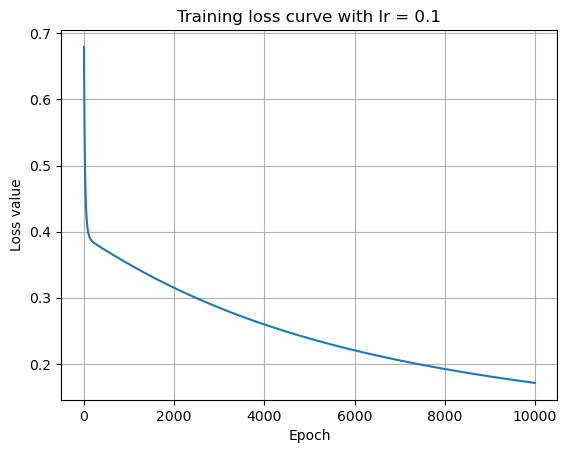

In [69]:
plt.plot(loss_3)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.title('Training loss curve with lr = 0.1')
plt.grid(True)
plt.show()

In [22]:
# Using sklearn logistic regression
X_sklearn = tfidf_matrix
y = np.array(df['Category'])

X_train_sklearn, X_test_sklearn, y_train_sklearn, y_test_sklearn = train_test_split(X_sklearn, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=50)
model.fit(X_train_sklearn, y_train_sklearn)

y_pred_sklearn = model.predict(X_test_sklearn)

accuracy = accuracy_score(y_test_sklearn, y_pred_sklearn)
print("Accuracy:", accuracy)

Accuracy: 0.95695067264574


# Confusion matrix

In [138]:
y_true = y_val
y_pred_1 = sigmoid(np.dot(X_val, w_1)+b_1)
y_pred_2 = sigmoid(np.dot(X_val, w_2)+b_2)
y_pred_3 = sigmoid(np.dot(X_val, w_3)+b_3)

# Applying the threshold to convert sigmoid outputs into binary (0 or 1)
y_pred_1_binary = (y_pred_1 >= 0.15).astype(int)
y_pred_2_binary = (y_pred_2 >= 0.14).astype(int)
y_pred_3_binary = (y_pred_3 >= 0.20).astype(int)

y_pred = [y_pred_1, y_pred_2, y_pred_3]
y_pred_binary = [y_pred_1_binary, y_pred_2_binary, y_pred_3_binary]


I was wrong when thinking the loss value was relate to the threshold and classification accuracy.
**Loss value** tell you how confident the probabilities is, and it not just the confidence of the function, it also about the correctness of the value

In [116]:
print(accuracy_score(y_val, y_pred_1_binary))
print(confusion_matrix(y_val, y_pred_1_binary))

print(accuracy_score(y_val, y_pred_2_binary))
print(confusion_matrix(y_val, y_pred_2_binary))

print(accuracy_score(y_val, y_pred_3_binary))
print(confusion_matrix(y_val, y_pred_3_binary))

# acc = accuracy_score(y_test, y_pred_1_binary)
# print(acc)

0.33253588516746413
[[166 558]
 [  0 112]]
0.5035885167464115
[[309 415]
 [  0 112]]
0.5322966507177034
[[333 391]
 [  0 112]]


For the first model(lr=0.1), the loss value for the weight and bias value is 0.28, which is very low, but the confidence of the model show it now so high(**only < 0.28**) for the label-1(spam) prediction

Now i will visualize the prob of model 1 by plotting a histogram for better understand

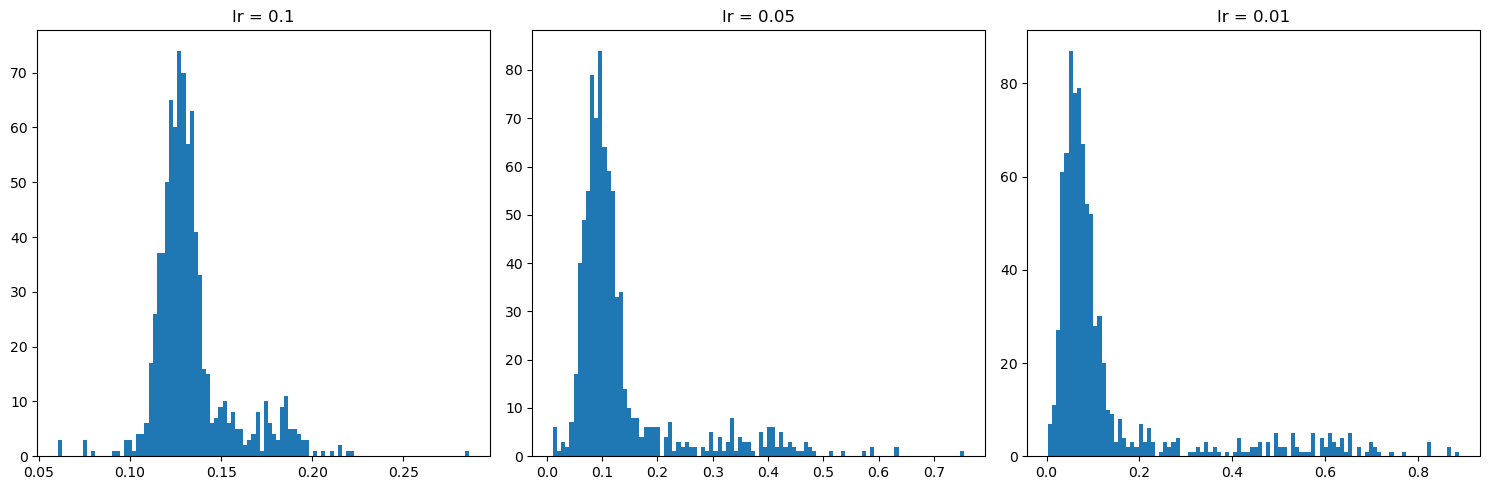

In [31]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

axs[0].hist(y_pred_1, bins=100)
axs[0].set_title('lr = 0.1')

axs[1].hist(y_pred_2, bins=100)
axs[1].set_title('lr = 0.05')

axs[2].hist(y_pred_3, bins=100)
axs[2].set_title('lr = 0.01')

plt.tight_layout()
plt.show()

To seeing how threshold affect the performance of the model, will plot ROC graph to visualize the impact of threshold to the sensitivity and specificity 

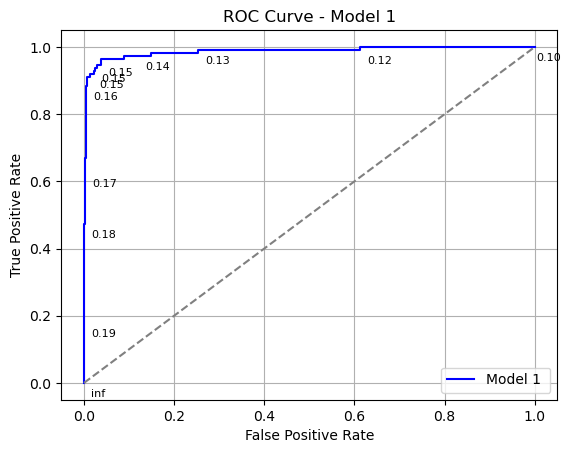

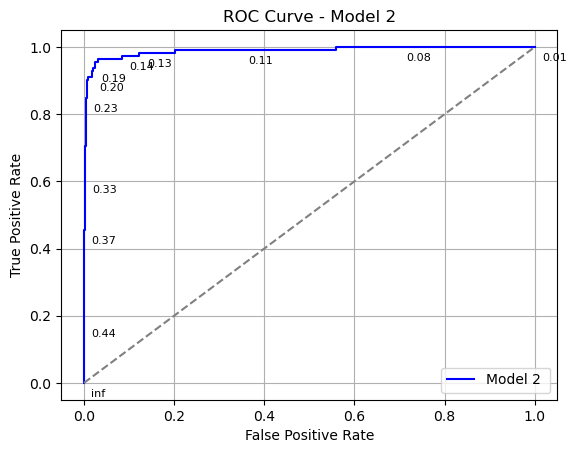

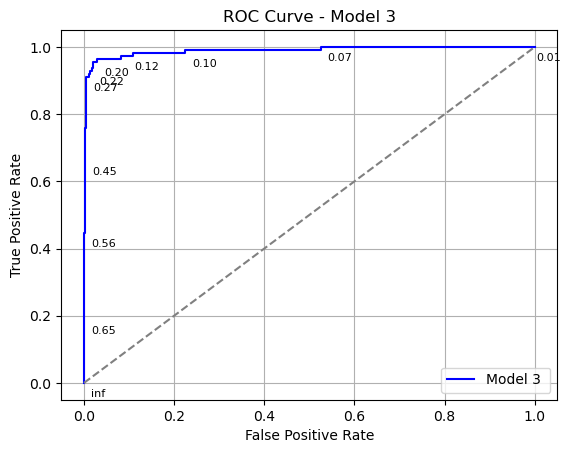

In [131]:
predictions = [
    ('Model 1', y_pred_1),
    ('Model 2', y_pred_2),
    ('Model 3', y_pred_3)
]

for name, y_pred in predictions:
    fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)

    plt.figure()
    plt.plot(fpr, tpr, color='blue', label=f'{name} ')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

    # Annotate a few threshold points
    for i in range(0, len(thresholds), max(1, len(thresholds)//10)):
        plt.annotate(f'{thresholds[i]:.2f}', (fpr[i], tpr[i]), textcoords="offset points", xytext=(5,-10), fontsize=8)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

The model may have a low accuracy when the False Positive is low, but in real life, we tend to avoid ham email classify to spam email, leading to miss infomation of user, there for, having the minimal False positive is nessary

Now i will have two way to implement this model, one it set so it balance between the TP and TF, second in to set the higest value to TP (1)

In [142]:
for i, (y_prob, y_value) in enumerate(zip(y_pred, y_pred_binary)):
    print(f"Model {i+1}: ")
    print(f"- Loss value: {log_loss(y_val, y_prob)}")
    print(f"- Accuracy: {accuracy_score(y_val, y_value)}")
    print(f"- Precision: {precision_score(y_val, y_value, pos_label=0)}")
    print(f"- Recall: {recall_score(y_val, y_value, pos_label=0)}")
    print(f"- F1 score: {f1_score(y_val, y_value, pos_label=0)}")
    print(f"- Confunsion matrix: \n{confusion_matrix(y_val, y_value)}\n")

Model 1: 
- Loss value: 0.35021827250482684
- Accuracy: 0.9665071770334929
- Precision: 0.9901408450704225
- Recall: 0.9709944751381215
- F1 score: 0.9804741980474198
- Confunsion matrix: 
[[703  21]
 [  7 105]]

Model 2: 
- Loss value: 0.23890644532501915
- Accuracy: 0.9222488038277512
- Precision: 0.9954887218045113
- Recall: 0.914364640883978
- F1 score: 0.953203743700504
- Confunsion matrix: 
[[662  62]
 [  3 109]]

Model 3: 
- Loss value: 0.17350775503809954
- Accuracy: 0.9700956937799043
- Precision: 0.9943422913719944
- Recall: 0.9709944751381215
- F1 score: 0.9825296995108316
- Confunsion matrix: 
[[703  21]
 [  4 108]]



# Apply regularization

In [15]:
def compute_loss_regularization(x_train, y_train, w, b, lambda_):
    m = x_train.shape[0]
    z = np.dot(x_train, w) + b
    h = sigmoid(z)
    epsilon = 1e-15
    
    loss = -np.mean(y_train * np.log(h + epsilon) + (1 - y_train) *  np.log(1 - h + epsilon))

    # Add L2 regularization
    l2_term = (lambda_ / (2 * m)) * np.sum(w**2)
    
    return loss + l2_term

In [18]:
def compute_gradient_regularization(x_train, y_train, w, b, lambda_):
    m = x_train.shape[0]
    z = np.dot(x_train, w) + b
    h = sigmoid(z)
    error = h - y_train
    dw = (np.dot(x_train.T, error) + lambda_ * w) / m
    db = np.sum(error) / m
    return dw, db

def gradient_descent_regularization(x_train, y_train, w, b, iters, lr, lambda_):
    losses = []
    for i in range(iters):
        dw_dj, db_dj = compute_gradient_regularization(x_train, y_train, w, b, lambda_)
        w = w - lr*dw_dj
        b = b - lr*db_dj
        loss = compute_loss_regularization(x_train, y_train, w, b, lambda_)
        losses.append(loss)
        if i % math.ceil(iters / 10) == 0:
            print(f"Iteration: {i}, Cost value: {compute_loss(x_train, y_train, w, b)}")

    print("Complete gradient descent!")
    print(f"Weight: {w}, Bias: {b}\n")

    return w, b, losses

    

We can see the above value, the model with learning rate at 0.1 perform little better then 2 others model, so we will implement regularization and find the best suited threshold for the model

In [19]:
iters = 10000
lr = 0.1
lambda_values = [0.001, 0.01, 0.1, 1, 10]
thresholds = np.arange(0.1, 0.9, 0.05)

w_rel = []
b_rel = []
loss_rel = []
y_pred_rel = []
y_pred_rel_bin = []

for lambda_ in lambda_values:
    m, n = X_train.shape
    w_init = np.zeros(n)
    b_init = 0

    w, b, loss = gradient_descent_regularization(X_train, y_train, w_init, b_init, iters, lr, lambda_)

    w_rel.append(w)
    b_rel.append(b)
    loss_rel.append(loss)

    probs = sigmoid(np.dot(X_val, w) + b)

    # Find best threshold based on precision
    best_threshold = 0.5
    best_precision = 0
    for t in thresholds:
        preds_bin = (probs >= t).astype(int)
        prec = precision_score(y_val, preds_bin, pos_label=0)
        if prec > best_precision:
            best_precision = prec
            best_threshold = t

    final_preds = (probs >= best_threshold).astype(int)
    y_pred_rel.append(probs)
    y_pred_rel_bin.append(final_preds)

    print(f"- Lambda: {lambda_}")
    print(f"- Best threshold{best_threshold}")
    print(f"- Loss value: {log_loss(y_val, probs)}")
    print(f"- Accuracy: {accuracy_score(y_val, final_preds)}")
    print(f"- Precision: {precision_score(y_val, final_preds, pos_label=0)}")
    print(f"- Recall: {recall_score(y_val, final_preds, pos_label=0)}")
    print(f"- F1 score: {f1_score(y_val, final_preds, pos_label=0)}")
    print(f"- Confusion matrix: \n{confusion_matrix(y_val, final_preds)}\n")


Iteration: 0, Cost value: 0.6795248531751672
Iteration: 1000, Cost value: 0.3505008384669417
Iteration: 2000, Cost value: 0.3148073039237619
Iteration: 3000, Cost value: 0.2847746530476879
Iteration: 4000, Cost value: 0.25960541863928194
Iteration: 5000, Cost value: 0.2384876277676163
Iteration: 6000, Cost value: 0.2206787987431698
Iteration: 7000, Cost value: 0.2055475346424814
Iteration: 8000, Cost value: 0.1925796649487081
Iteration: 9000, Cost value: 0.1813659506647984
Complete gradient descent!
Weight: [ 0.14221022  0.09488567  0.04772988 ... -0.04998086 -0.84603116
 -0.05935862], Bias: -1.6965738295294641

- Lambda: 0.001
- Best threshold0.1
- Loss value: 0.18020770183638504
- Accuracy: 0.8050239234449761
- Precision: 0.9964601769911504
- Recall: 0.7776243093922652
- F1 score: 0.873545384018619
- Confusion matrix: 
[[563 161]
 [  2 110]]

Iteration: 0, Cost value: 0.6795248531751672
Iteration: 1000, Cost value: 0.35050570361166034
Iteration: 2000, Cost value: 0.31482373983471734


Running the model again will take a large amount of time, now i will take the saved weight and bias value of each lambda to see the best threshold on a smaller gap

In [32]:
thresholds = np.arange(0.05, 0.4, 0.02)

for i, lambda_ in enumerate(lambda_values):
    # Find best threshold based on precision
    best_threshold = 0.5
    best_precision = 0
    for t in thresholds:
        preds_bin = (probs >= t).astype(int)
        prec = precision_score(y_val, preds_bin, pos_label=0)
        f1 = f1_score(y_val, preds_bin, pos_label=0)
        if prec > best_precision and prec != 1:
            best_precision = prec
            best_threshold = t
            
    probs = sigmoid(np.dot(X_val, w_rel[i]) + b)
    
    final_preds = (probs >= best_threshold).astype(int)
    y_pred_rel.append(probs)
    y_pred_rel_bin.append(final_preds)

    print(f"- Lambda: {lambda_}")
    print(f"- Best threshold: {best_threshold:0.02f}")
    print(f"- Loss value: {log_loss(y_val, probs):0.02f}")
    print(f"- Accuracy: {accuracy_score(y_val, final_preds):0.02f}")
    print(f"- Precision: {precision_score(y_val, final_preds, pos_label=0)}")
    print(f"- Recall: {recall_score(y_val, final_preds, pos_label=0):0.02f}")
    print(f"- F1 score: {f1_score(y_val, final_preds, pos_label=0):0.02f}")
    print(f"- Confusion matrix: \n{confusion_matrix(y_val, final_preds)}\n")


- Lambda: 0.001
- Best threshold: 0.11
- Loss value: 0.18
- Accuracy: 0.86
- Precision: 0.9967373572593801
- Recall: 0.84
- F1 score: 0.91
- Confusion matrix: 
[[611 113]
 [  2 110]]

- Lambda: 0.01
- Best threshold: 0.09
- Loss value: 0.18
- Accuracy: 0.75
- Precision: 0.9980769230769231
- Recall: 0.72
- F1 score: 0.83
- Confusion matrix: 
[[519 205]
 [  1 111]]

- Lambda: 0.1
- Best threshold: 0.09
- Loss value: 0.18
- Accuracy: 0.75
- Precision: 0.998062015503876
- Recall: 0.71
- F1 score: 0.83
- Confusion matrix: 
[[515 209]
 [  1 111]]

- Lambda: 1
- Best threshold: 0.09
- Loss value: 0.19
- Accuracy: 0.72
- Precision: 0.9979633401221996
- Recall: 0.68
- F1 score: 0.81
- Confusion matrix: 
[[490 234]
 [  1 111]]

- Lambda: 10
- Best threshold: 0.09
- Loss value: 0.28
- Accuracy: 0.28
- Precision: 1.0
- Recall: 0.17
- F1 score: 0.29
- Confusion matrix: 
[[121 603]
 [  0 112]]



After validation process, i choose the model with the learning rate = 0.1 and lambda = 0.001, with threshold 0.11 to test on the test data

In [33]:
w_test = w_rel[0]
b_test = b_rel[0]
threshold_test = 0.11

probs_test = sigmoid(np.dot(X_test, w_test)+b_test)
bin_test = (probs_test >= 0.11).astype(int)

print(f"- Loss value: {log_loss(y_test, probs_test):0.02f}")
print(f"- Accuracy: {accuracy_score(y_test, bin_test):0.02f}")
print(f"- Precision: {precision_score(y_test, bin_test, pos_label=0)}")
print(f"- Recall: {recall_score(y_test, bin_test, pos_label=0):0.02f}")
print(f"- F1 score: {f1_score(y_test, bin_test, pos_label=0):0.02f}")
print(f"- Confusion matrix: \n{confusion_matrix(y_test, bin_test)}\n")

- Loss value: 0.19
- Accuracy: 0.81
- Precision: 0.9964973730297724
- Recall: 0.79
- F1 score: 0.88
- Confusion matrix: 
[[569 155]
 [  2 110]]

